In [1]:
import sys
print(sys.executable)
#should be AI project


C:\Users\Johanna\anaconda3\envs\AI_project\python.exe


In [19]:
!pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   - -------------------------------------- 2.6/56.8 MB 12.5 MB/s eta 0:00:05
   --- ------------------------------------ 5.2/56.8 MB 12.7 MB/s eta 0:00:05
   ----- ---------------------------------- 8.1/56.8 MB 13.2 MB/s eta 0:00:04
   -------- ------------------------------- 11.5/56.8 MB 13.9 MB/s eta 0:00:04
   ---------- ----------------------------- 15.2/56.8 MB 14.5 MB/s eta 0:00:03
   ------------- -------------------------- 18.6/56.8 MB 14.9 MB/s eta 0:00:03
   --------------- ------------------------ 21.5/56.8 MB 14.8 MB/s eta 0:00:03
   ----------------- ---------------------- 24.9/56.8 MB 15.0 MB/s eta 0:00:03
   -------------------- ------------------- 28.6/56.8 MB 15.2 MB/s eta 0:00:02
   ---------------------- ----------------- 32.2/56.8 MB 15.4 MB/s eta 0:00:02
   ------------------------- -------------- 35.7/56.8 MB 15.5 MB/s eta 0:

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from functools import reduce
from datetime import time
from xgboost import XGBRegressor


In [3]:
df_2_full = pd.read_parquet("data/processed/df_2_full_v2.parquet")
df_2_full.head()

##otherwise
#df_2_full = pd.read_csv("data/processed/df_2_full.csv",sep=";", parse_dates=['Datetime'])

#df_2_full['Time_only'] = df_2_full['Datetime'].dt.time
#df_2_full['Date_only']=df_2_full['Datetime'].dt.date##
#df_2_full.head()


,Datetime,DP_ID,PORTAL,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Time_only,Date_only,PORTAL_clean,SPEED_MS_AVG_filled,FLOW_filled
0,2021-06-01 04:00:00,539,"E4S 56,160",240,48,16,8,4,19.64,9.0,04:00:00,2021-06-01,56160,19.64,9.0
1,2021-06-01 04:00:00,536,"E4S 56,160",240,48,16,8,4,28.35,2.0,04:00:00,2021-06-01,56160,28.35,2.0
2,2021-06-01 04:00:00,751,"E4S 55,620",240,48,16,8,4,21.53,19.0,04:00:00,2021-06-01,55620,21.53,19.0
3,2021-06-01 04:00:00,740,"E4S 56,160",240,48,16,8,4,21.99,17.0,04:00:00,2021-06-01,56160,21.99,17.0
4,2021-06-01 04:00:00,1254,"E4S 55,620",240,48,16,8,4,24.53,4.0,04:00:00,2021-06-01,55620,24.53,4.0


In [4]:
target_sensor = 1076
same_portal="55620"
neighbour_portal = "56160"

same_portal_sensors = df_2_full[df_2_full['PORTAL_clean'] == same_portal]['DP_ID'].unique()
same_sensors = [s for s in same_portal_sensors if s != target_sensor]


neighbour_sensors = df_2_full[df_2_full['PORTAL_clean'] == neighbour_portal]['DP_ID'].unique()
all_sensors=df_2_full['DP_ID'].unique()
except_target_sensors = [s for s in all_sensors if s != target_sensor]




prediction same time

In [5]:
df_all = []
for sensor in all_sensors:
    df_sensor = df_2_full[df_2_full['DP_ID'] == sensor].copy()
    df_sensor = df_sensor.rename(columns={
        f'FLOW_filled': f'SENSOR_{sensor}_FLOW'
    })
    df_sensor = df_sensor.rename(columns={
        f'SPEED_MS_AVG_filled': f'SENSOR_{sensor}_SPEED' 
    })
    df_sensor = df_sensor[['Datetime'] + [f'SENSOR_{sensor}_FLOW' ]+[f'SENSOR_{sensor}_SPEED' ]]
    df_all.append(df_sensor)
df_all = reduce(lambda l, r: pd.merge(l, r, on='Datetime', how='inner'), df_all)
df_all.head()
print(df_all.columns)


Index(['Datetime', 'SENSOR_539_FLOW', 'SENSOR_539_SPEED', 'SENSOR_536_FLOW',
       'SENSOR_536_SPEED', 'SENSOR_751_FLOW', 'SENSOR_751_SPEED',
       'SENSOR_740_FLOW', 'SENSOR_740_SPEED', 'SENSOR_1254_FLOW',
       'SENSOR_1254_SPEED', 'SENSOR_1076_FLOW', 'SENSOR_1076_SPEED'],
      dtype='object')


In [30]:
df_all.to_parquet("data/processed/df_all.parquet", index=False)


In [51]:
flow_features_same = [
    f'SENSOR_{sensor}_FLOW'
    for sensor in same_sensors
    #for i in range(15)
]
flow_features_neighbour = [
    f'SENSOR_{sensor}_FLOW'
    for sensor in neighbour_sensors
    #for i in range(15)
]
speed_features_same = [
    f'SENSOR_{sensor}_SPEED'
    for sensor in same_sensors
    #for i in range(15)
]
speed_features_neighbour = [
    f'SENSOR_{sensor}_SPEED'
    for sensor in neighbour_sensors
    #for i in range(15)
]

In [49]:

#df_train, df_test = train_test_split(df_all, test_size=0.2, shuffle=False)
df_train, df_test = train_test_split(df_all, test_size=0.2, random_state=42)


In [52]:


model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_same], df_train[f'SENSOR_{target_sensor}_FLOW' ])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_same], df_train[f'SENSOR_{target_sensor}_SPEED' ])

# prediction
y_pred = model_flow.predict(df_test[flow_features_same])
y_test=df_test[f'SENSOR_{target_sensor}_FLOW']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_same])
y_test=df_test[f'SENSOR_{target_sensor}_SPEED']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Baseline Linear Regression (FLOW) -> RMSE: 3.992, MAE: 3.167, R2: 0.618
Baseline Linear Regression (SPEED) -> RMSE: 1.007, MAE: 0.732, R2: 0.723


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [53]:



model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_neighbour], df_train[f'SENSOR_{target_sensor}_FLOW' ])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_neighbour], df_train[f'SENSOR_{target_sensor}_SPEED' ])

# prediction
y_pred = model_flow.predict(df_test[flow_features_neighbour])
y_test=df_test[f'SENSOR_{target_sensor}_FLOW']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_neighbour])
y_test=df_test[f'SENSOR_{target_sensor}_SPEED']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Baseline Linear Regression (FLOW) -> RMSE: 3.349, MAE: 2.604, R2: 0.731
Baseline Linear Regression (SPEED) -> RMSE: 1.223, MAE: 0.808, R2: 0.591


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


prediction current time based on the last 15

In [96]:
portal_to_sensors = df_2_full.groupby("PORTAL_clean")["DP_ID"].unique().to_dict()
print(portal_to_sensors)
sensor_to_portal = {}
for portal, sensor_list in portal_to_sensors.items():
    for sensor in sensor_list:
        sensor_to_portal[sensor] = portal

{'55620': array([ 751, 1254, 1076], dtype=int64), '56160': array([539, 536, 740], dtype=int64)}


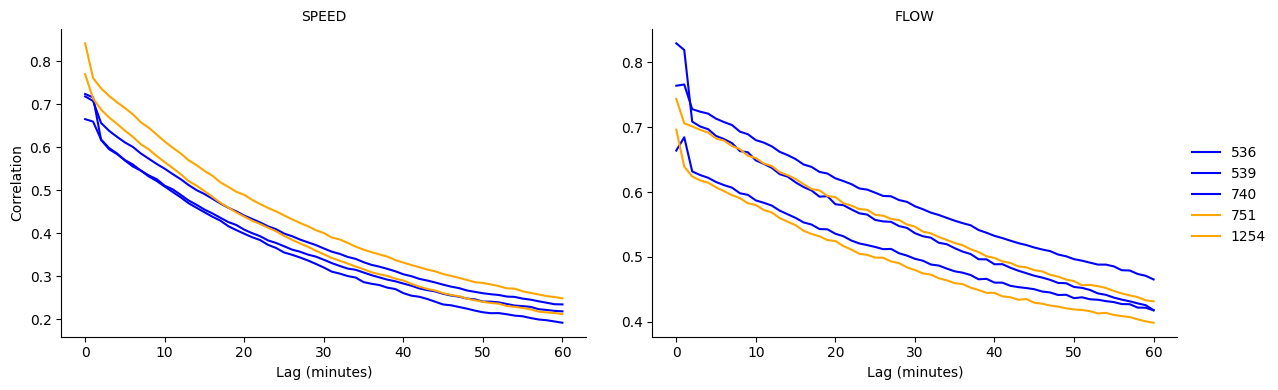

feature  sensor
SPEED    751       0.841392
FLOW     539       0.829610
SPEED    1254      0.769593
FLOW     740       0.766042
         751       0.743899
SPEED    539       0.723572
         740       0.717904
FLOW     1254      0.696346
         536       0.684610
SPEED    536       0.665095
Name: corr, dtype: float64


In [135]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features = ["SPEED", "FLOW"]
max_lag = 60

results = []

for feat in features:
    target_col = f"SENSOR_{target_sensor}_{feat}" #SENSOR_1076_FLOW
    for sensor in except_target_sensors:
        sensor_col = f"SENSOR_{sensor}_{feat}"
        for lag in range(max_lag + 1):
            corr = df_all[target_col].corr(df_all[sensor_col].shift(lag))
            results.append({
                "feature": feat,
                "sensor": sensor,
                "lag": lag,
                "corr": corr
            })

lag_corr_df = pd.DataFrame(results)

# Plot getrennt nach Feature
#g = sns.FacetGrid(lag_corr_df, col="feature", sharey=False, height=4, aspect=1.5)
#g.map_dataframe(sns.lineplot, x="lag", y="corr", hue="sensor")
#g.add_legend()
#g.set_axis_labels("Lag (minutes)", "Correlation")
#g.set_titles("{col_name}")
#plt.show()

lag_corr_df["portal"] = lag_corr_df["sensor"].map(sensor_to_portal)
portal_colors = {
    "56160": "blue",
    "55620": "orange",
    # weitere Portale nach Bedarf
}



g = sns.FacetGrid(lag_corr_df, col="feature", sharey=False, height=4, aspect=1.5)

def portal_lineplot(data, **kwargs):
    for sensor, group in data.groupby("sensor"):
        portal = sensor_to_portal.get(sensor, "unknown")
        color = portal_colors.get(portal, "gray")
        kwargs_clean = {k: v for k, v in kwargs.items() if k != "color"}
        sns.lineplot(
            data=group,
            x="lag",
            y="corr",
            label=sensor,
            color=color,
            **kwargs_clean
        )

g.map_dataframe(portal_lineplot)
g.add_legend()
g.set_axis_labels("Lag (minutes)", "Correlation")
g.set_titles("{col_name}")
plt.savefig("Plots/Correlation_lag_flow_speed.eps")
plt.show()


# stärkste Korrelation pro Feature und Sensor
top_sensors = lag_corr_df.groupby(["feature", "sensor"])["corr"].max().sort_values(ascending=False)
print(top_sensors)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1000x500 with 0 Axes>

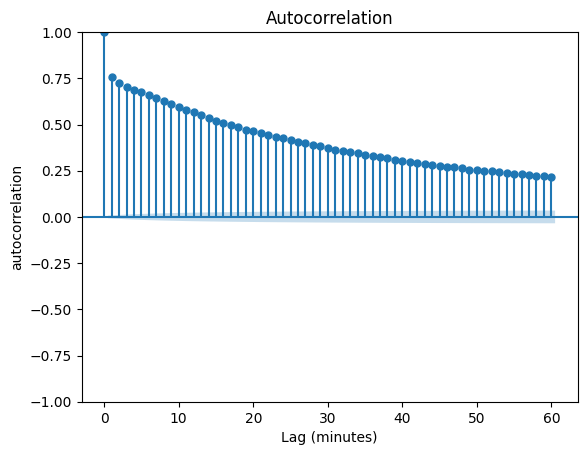

17


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1000x500 with 0 Axes>

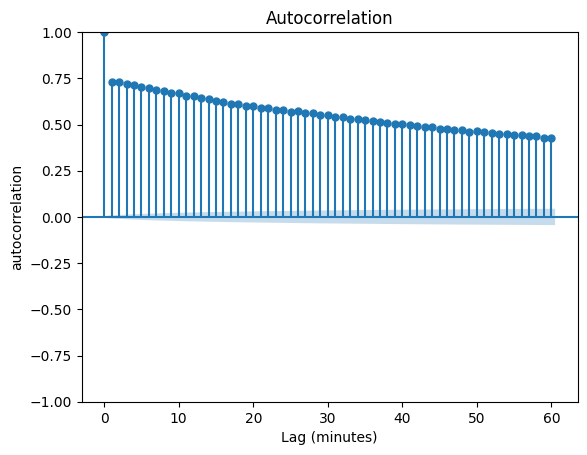

41


In [134]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf


plt.figure(figsize=(10,5))
plot_acf(df_all['SENSOR_1076_SPEED'].dropna(), lags=60, alpha=0.05)
plt.xlabel("Lag (minutes)")
plt.ylabel("autocorrelation")
plt.savefig("Plots/Speed/autocorrelation.eps")
plt.show()

acf_values = acf(df_all['SENSOR_1076_SPEED'].dropna(), nlags=60)

lag_threshold = np.argmax(acf_values < 0.5)

print(lag_threshold)

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf


plt.figure(figsize=(10,5))
plot_acf(df_all['SENSOR_1076_FLOW'].dropna(), lags=60, alpha=0.05)
plt.xlabel("Lag (minutes)")
plt.ylabel("autocorrelation")
plt.savefig("Plots/Flow/autocorrelation.eps")
plt.show()

acf_values = acf(df_all['SENSOR_1076_FLOW'].dropna(), nlags=60)

lag_threshold = np.argmax(acf_values < 0.5)

print(lag_threshold)

In [118]:
selected_lags = lag_corr_df[lag_corr_df["corr"] >= 0.75 * lag_corr_df.groupby(["feature", "sensor"])["corr"].transform("max")]
print(selected_lags)
print(selected_lags.groupby(["feature", "sensor"])["lag"].max())
print(selected_lags.groupby(["feature", "sensor"])["lag"].max().groupby(["feature"]).mean())


    feature  sensor  lag      corr portal
0     SPEED     539    0  0.723572  56160
1     SPEED     539    1  0.715615  56160
2     SPEED     539    2  0.617038  56160
3     SPEED     539    3  0.595334  56160
4     SPEED     539    4  0.583892  56160
..      ...     ...  ...       ...    ...
565    FLOW    1254   16  0.540263  55620
566    FLOW    1254   17  0.535433  55620
567    FLOW    1254   18  0.531614  55620
568    FLOW    1254   19  0.525945  55620
569    FLOW    1254   20  0.524394  55620

[171 rows x 5 columns]
feature  sensor
FLOW     536       25
         539       14
         740       30
         751       27
         1254      20
SPEED    536       11
         539        7
         740       10
         751        8
         1254       9
Name: lag, dtype: int64
feature
FLOW     23.2
SPEED     9.0
Name: lag, dtype: float64


In [119]:
#nlags=30
nlags=15

In [120]:
def build_lag_features(df, target_col, lags=nlags):
    df = df.sort_values('Datetime')
    for i in range(1, lags + 1):
        df[f'{target_col}_lag_{i}'] = df.groupby('DP_ID')[target_col].shift(i)
    return df


In [121]:
df_lagged = build_lag_features(df_2_full, 'FLOW_filled', lags=nlags)
df_lagged = build_lag_features(df_lagged,"SPEED_MS_AVG_filled", lags=nlags)
df_lagged = df_lagged[df_lagged[f'FLOW_filled_lag_{nlags}'].notna()]
#decay_weights = np.exp(-np.linspace(0, 2, 15))  # z. B. λ=2
#df_lagged['FLOW_decay_feature'] = sum(
#    df_lagged[f'FLOW_filled_lag_{i+1}'] * decay_weights[i]
#    for i in range(15)
#)
print(df_lagged.isna().sum())
print(df_lagged.shape)


Datetime                          0
DP_ID                             0
PORTAL                            0
Interval_1                        0
Interval_5                        0
Interval_15                       0
Interval_30                       0
Interval_60                       0
SPEED_MS_AVG                  22876
FLOW                          22876
Time_only                         0
Date_only                         0
PORTAL_clean                      0
SPEED_MS_AVG_filled               0
FLOW_filled                       0
FLOW_future_sum                  84
SPEED_future_mean                84
FLOW_filled_lag_1                 0
FLOW_filled_lag_2                 0
FLOW_filled_lag_3                 0
FLOW_filled_lag_4                 0
FLOW_filled_lag_5                 0
FLOW_filled_lag_6                 0
FLOW_filled_lag_7                 0
FLOW_filled_lag_8                 0
FLOW_filled_lag_9                 0
FLOW_filled_lag_10                0
FLOW_filled_lag_11          

In [122]:
df_lagged_all = []
for sensor in except_target_sensors:
    df_sensor = df_lagged[df_lagged['DP_ID'] == sensor].copy()
    df_sensor = df_sensor.rename(columns={
        f'FLOW_filled_lag_{i+1}': f'SENSOR_{sensor}_FLOW_lag_{i+1}' for i in range(nlags)
    })
    df_sensor = df_sensor.rename(columns={
        f'SPEED_MS_AVG_filled_lag_{i+1}': f'SENSOR_{sensor}_SPEED_lag_{i+1}' for i in range(nlags)
    })
    df_sensor = df_sensor[['Datetime'] + [f'SENSOR_{sensor}_FLOW_lag_{i+1}' for i in range(nlags)]+[f'SENSOR_{sensor}_SPEED_lag_{i+1}' for i in range(nlags)]]
    df_lagged_all.append(df_sensor)
df_lagged_all = reduce(lambda l, r: pd.merge(l, r, on='Datetime', how='inner'), df_lagged_all)
df_lagged_all=df_lagged_all.merge(df_2_full[df_2_full['DP_ID']==target_sensor][["Datetime","FLOW_filled","SPEED_MS_AVG_filled"]], on=['Datetime'], how='left')
#df_lagged_all = df_lagged_all.rename(columns={f'FLOW_filled': f'SENSOR_{target_sensor}_FLOW_filled'})
df_lagged_all.head()
print(df_lagged_all.columns)

Index(['Datetime', 'SENSOR_539_FLOW_lag_1', 'SENSOR_539_FLOW_lag_2',
       'SENSOR_539_FLOW_lag_3', 'SENSOR_539_FLOW_lag_4',
       'SENSOR_539_FLOW_lag_5', 'SENSOR_539_FLOW_lag_6',
       'SENSOR_539_FLOW_lag_7', 'SENSOR_539_FLOW_lag_8',
       'SENSOR_539_FLOW_lag_9',
       ...
       'SENSOR_1254_SPEED_lag_8', 'SENSOR_1254_SPEED_lag_9',
       'SENSOR_1254_SPEED_lag_10', 'SENSOR_1254_SPEED_lag_11',
       'SENSOR_1254_SPEED_lag_12', 'SENSOR_1254_SPEED_lag_13',
       'SENSOR_1254_SPEED_lag_14', 'SENSOR_1254_SPEED_lag_15', 'FLOW_filled',
       'SPEED_MS_AVG_filled'],
      dtype='object', length=153)


In [123]:
flow_features_same = [
    f'SENSOR_{sensor}_FLOW_lag_{i+1}'
    for sensor in same_sensors
    for i in range(nlags)
]
flow_features_neighbour = [
    f'SENSOR_{sensor}_FLOW_lag_{i+1}'
    for sensor in neighbour_sensors
    for i in range(nlags)
]
speed_features_same = [
    f'SENSOR_{sensor}_SPEED_lag_{i+1}'
    for sensor in same_sensors
    for i in range(nlags)
]
speed_features_neighbour = [
    f'SENSOR_{sensor}_SPEED_lag_{i+1}'
    for sensor in neighbour_sensors
    for i in range(nlags)
]

In [124]:
df_train, df_test = train_test_split(df_lagged_all, test_size=0.2, random_state=42)

#split_time = df_2_full['Datetime'].quantile(0.8)
#print(split_time)

#df_train = df_lagged_all[df_lagged_all['Datetime'] <= split_time]
#df_test = df_lagged_all[df_lagged_all['Datetime'] > split_time]


In [125]:
#saame portal


model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_same], df_train['FLOW_filled'])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_same], df_train['SPEED_MS_AVG_filled'])



#df_lagged['FLOW_future_mean'] = df_lagged.groupby('DP_ID')['FLOW_filled'].shift(-1).rolling(15).mean()

# prediction
y_pred = model_flow.predict(df_test[flow_features_same])
y_test=df_test['FLOW_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Speed-Intercept:", model_speed.intercept_)
print("Speed-Koeffizienten:", model_speed.coef_)
print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_same])
y_test=df_test['SPEED_MS_AVG_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Flow-Intercept:", model_flow.intercept_)

print("Flow-Koeffizienten:", model_flow.coef_)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Speed-Intercept: 2.3609388107823115
Speed-Koeffizienten: [ 0.23968908  0.14052723  0.09467139  0.06799117  0.05838131  0.04417238
  0.01506743  0.0243919   0.01061808  0.00364182  0.00157054  0.00203307
 -0.0053148   0.00602233 -0.0021787   0.11161594  0.02044535  0.00783916
  0.00393106 -0.00664877 -0.00195226 -0.00278029  0.00132639 -0.00180493
  0.0039229   0.00300601  0.00643609 -0.00562622  0.00045509 -0.00599988]
Baseline Linear Regression (FLOW) -> RMSE: 3.870, MAE: 2.997, R2: 0.644
Flow-Intercept: -0.07491930055591567
Flow-Koeffizienten: [ 0.12754204  0.11906008  0.09794275  0.08209083  0.05227276  0.05244106
  0.03699901  0.03299464  0.01195648  0.0177557   0.00935001  0.01668
  0.00329194  0.01026273  0.01255077  0.08922874  0.03756212  0.02440156
  0.02018557  0.01120669  0.0052227   0.00169357  0.00309429 -0.00050882
  0.0088585   0.0035147   0.0068232   0.00139825  0.00190002  0.00590812]
Baseline Linear Regression (SPEED) -> RMSE: 1.109, MAE: 0.817, R2: 0.678


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [126]:
#neighbour


model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_neighbour], df_train['FLOW_filled'])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_neighbour], df_train['SPEED_MS_AVG_filled'])



#df_lagged['FLOW_future_mean'] = df_lagged.groupby('DP_ID')['FLOW_filled'].shift(-1).rolling(15).mean()

# Vorhersage
y_pred = model_flow.predict(df_test[flow_features_neighbour])
y_test=df_test['FLOW_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_neighbour])
y_test=df_test['SPEED_MS_AVG_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Baseline Linear Regression (FLOW) -> RMSE: 3.274, MAE: 2.515, R2: 0.745
Baseline Linear Regression (SPEED) -> RMSE: 1.241, MAE: 0.789, R2: 0.597


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Predict total flow /average speed for the next 15 mins

In [127]:
df_2_full['FLOW_future_sum'] = (
    df_2_full.groupby('DP_ID')['FLOW_filled']
    .rolling(15, min_periods=15)
    .sum()
    .shift(-14)  # damit die Summe bei t=07:02 die Werte von 07:02–07:16 enthält
    .reset_index(level=0, drop=True)
)
df_2_full['SPEED_future_mean'] = (
    df_2_full.groupby('DP_ID')['SPEED_MS_AVG_filled']
    .rolling(15, min_periods=15)
    .mean()
    .shift(-14)  # damit die Summe bei t=07:02 die Werte von 07:02–07:16 enthält
    .reset_index(level=0, drop=True)
)


df_lagged_all=df_lagged_all.merge(df_2_full[df_2_full['DP_ID']==target_sensor][["Datetime","FLOW_future_sum","SPEED_future_mean"]], on=['Datetime'], how='left')
print(df_lagged_all.shape)
df_lagged_all = df_lagged_all[df_lagged_all['Datetime'].dt.time <= time(9, 45)]
print(df_lagged_all.shape)

#print(df_lagged_all["Datetime"]dt.time.min(), df_lagged_all["Datetime"].dt.date.max())
df_lagged_all.head(20)
print(df_lagged_all.isna().sum())


(76156, 155)
(72991, 155)
Datetime                    0
SENSOR_539_FLOW_lag_1       0
SENSOR_539_FLOW_lag_2       0
SENSOR_539_FLOW_lag_3       0
SENSOR_539_FLOW_lag_4       0
                           ..
SENSOR_1254_SPEED_lag_15    0
FLOW_filled                 0
SPEED_MS_AVG_filled         0
FLOW_future_sum             0
SPEED_future_mean           0
Length: 155, dtype: int64


In [128]:
df_train, df_test = train_test_split(df_lagged_all, test_size=0.2, random_state=42)

#split_time = df_2_full['Datetime'].quantile(0.8)
#print(split_time)

#df_train = df_lagged_all[df_lagged_all['Datetime'] <= split_time]
#df_test = df_lagged_all[df_lagged_all['Datetime'] > split_time]


In [129]:
#same portal




model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_same], df_train['FLOW_future_sum'])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_same], df_train['SPEED_future_mean'])

#df_lagged['FLOW_future_mean'] = df_lagged.groupby('DP_ID')['FLOW_filled'].shift(-1).rolling(15).mean()

# Vorhersage
y_pred = model_flow.predict(df_test[flow_features_same])
y_test=df_test['FLOW_future_sum']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")


y_pred = model_speed.predict(df_test[speed_features_same])
y_test=df_test['SPEED_future_mean']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Baseline Linear Regression (FLOW) -> RMSE: 33.543, MAE: 23.809, R2: 0.836
Baseline Linear Regression (SPEED) -> RMSE: 0.861, MAE: 0.462, R2: 0.709


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [130]:
#neighbour portal


model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_neighbour], df_train['FLOW_future_sum'])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_neighbour], df_train['SPEED_future_mean'])

#df_lagged['FLOW_future_mean'] = df_lagged.groupby('DP_ID')['FLOW_filled'].shift(-1).rolling(15).mean()

# Vorhersage
y_pred = model_flow.predict(df_test[flow_features_neighbour])
y_test=df_test['FLOW_future_sum']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")


y_pred = model_speed.predict(df_test[speed_features_neighbour])
y_test=df_test['SPEED_future_mean']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Baseline Linear Regression (FLOW) -> RMSE: 28.474, MAE: 19.559, R2: 0.882
Baseline Linear Regression (SPEED) -> RMSE: 1.051, MAE: 0.513, R2: 0.566


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGB-Boost

In [132]:


model_flow = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_flow.fit(df_train[flow_features_same], df_train['FLOW_future_sum'])

model_speed = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_speed.fit(df_train[speed_features_same], df_train['SPEED_future_mean'])




y_pred = model_flow.predict(df_test[flow_features_same])
y_test = df_test['FLOW_future_sum']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_same])
y_test = df_test['SPEED_future_mean']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

XGBoost Regression (FLOW) -> RMSE: 28.647, MAE: 20.634, R²: 0.880
XGBoost Regression (SPEED) -> RMSE: 0.810, MAE: 0.401, R²: 0.742


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [131]:
from xgboost import XGBRegressor
model_flow = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_flow.fit(df_train[flow_features_neighbour], df_train['FLOW_future_sum'])

model_speed = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_speed.fit(df_train[speed_features_neighbour], df_train['SPEED_future_mean'])




y_pred = model_flow.predict(df_test[flow_features_neighbour])
y_test = df_test['FLOW_future_sum']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_neighbour])
y_test = df_test['SPEED_future_mean']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

XGBoost Regression (FLOW) -> RMSE: 24.460, MAE: 17.192, R²: 0.913
XGBoost Regression (SPEED) -> RMSE: 0.936, MAE: 0.424, R²: 0.655


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [87]:
df_lagged_all.to_parquet("data/processed/df_lagged_15_all.parquet", index=False)
#df_lagged_all.to_parquet("data/processed/df_lagged_30_all.parquet", index=False)
